In [1]:
from glob import glob
import sys, scipy
from scipy.stats import chi2, poisson
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

from prettytable import PrettyTable

In [2]:
import ROOT as rt
import root_numpy as rtnp
from utility_func import *

Welcome to JupyROOT 6.10/08


/Users/olmo/programs/root-6.10.08/lib/ROOT.py:318: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.


In [3]:
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import keras
print keras.__version__

2.1.2


In [4]:
do_training = 1

# Get the samples

In [5]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'allJetMass',
                       'allMuPt', 'allMuMass',
                       'allElePt','allEleMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'METp', 'METo',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad']

Nf_lognorm = 10
Nf_gauss = 2
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 2

sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)
# print 'Activated HLF:'
# for n in np.array(hlf_features)[sel]:
#     print '\t', n

In [6]:
data_folder = '../../data/HLF_ONLY/'
TrainSamplesName = ['Wlnu', 'qcd', 'ttbar']
BSM_samples = ['Ato4l', 'Zprime', 'Wprime', 'leptoquark']

N_train_max = int(2e6)

In [7]:
trigger_rate = np.array([440., 251., 2.51])
fraction = trigger_rate/ np.sum(trigger_rate)

raw_sample = {}
l = np.zeros(3)
for i,n in enumerate(TrainSamplesName):
    raw_sample[n] = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    l[i] = raw_sample[n].shape[0]
    
i_min = np.argmin(l/fraction)
print 'Limiting stat. sample:', TrainSamplesName[i_min]

N_train = min(0.8*l[i_min], N_train_max)

x_train_s = {}
x_val_s = {}

table = PrettyTable(['Sample', 'Evts tot', 'Train', 'Val'])

for i,n in enumerate(TrainSamplesName):
    N_train_aux = int(N_train * fraction[i]/fraction[i_min])
    x_train_s[n] = raw_sample[n][:N_train_aux, sel]
    x_val_s[n] = raw_sample[n][N_train_aux : int(N_train_aux*1.2) - 1, sel]
    table.add_row([n, raw_sample[n].shape[0], N_train_aux, x_val_s[n].shape[0]])
print table
    
x_train = np.concatenate((x_train_s['Wlnu'], x_train_s['qcd'], x_train_s['ttbar']))
x_val = np.concatenate((x_val_s['Wlnu'], x_val_s['qcd'], x_val_s['ttbar']))

Limiting stat. sample: qcd
+--------+----------+---------+--------+
| Sample | Evts tot |  Train  |  Val   |
+--------+----------+---------+--------+
|  Wlnu  | 5003421  | 1635460 | 327091 |
|  qcd   | 1166195  |  932956 | 186590 |
| ttbar  | 5001726  |   9329  |  1864  |
+--------+----------+---------+--------+


# Start the Classifier declaration

In [36]:
original_dim = x_train.shape[1]
intermediate_dim = 15
act_fun = 'relu'

In [37]:
clf = {}

for n in BSM_samples:
    inputs = Input(shape=(original_dim,), name='Input_'+n)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h1_'+n)(inputs)
#     mdl = Dropout(0.2)(mdl)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h2_'+n)(mdl)
    mdl = Dropout(0.25)(mdl)
    mdl = Dense(1, activation='sigmoid', name='out_'+n)(mdl)
    clf[n] = Model(inputs=inputs, outputs=mdl)
    
    clf[n].compile(loss='binary_crossentropy', optimizer='adam')

Gather the signal data

In [10]:
x_sig = {}
for n in BSM_samples:
    s = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    x_sig[n] = s[:N_train_max, sel]

### Do the training

In [38]:
for n in BSM_samples:
    print '\n\n------------------ Training', n, '--------------------'
    l_bsm = int(x_sig[n].shape[0]*0.8)
    aux_x = np.concatenate(( x_train, x_sig[n][:l_bsm] ))
    aux_y = np.concatenate(( np.zeros(x_train.shape[0]), np.ones(l_bsm) ))
    aux_xval = np.concatenate(( x_val, x_sig[n][l_bsm:] ))
    aux_yval = np.concatenate(( np.zeros(x_val.shape[0]), np.ones(x_sig[n].shape[0] - l_bsm) ))
    
    clf[n].training_history = clf[n].fit(x=aux_x, y=aux_y, batch_size=1000, epochs=50,
                          shuffle=True,
                          validation_data= (aux_xval, aux_yval),
                          callbacks = [
                                        EarlyStopping(monitor='val_loss', patience=4, verbose=1),
                                        ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1),
                                        TerminateOnNaN()
                                      ]
                         )



------------------ Training Ato4l --------------------
Train on 2615911 samples, validate on 525087 samples
Epoch 1/50
2615911/2615911 [==============================] - 8s 3us/step - loss: 0.1567 - val_loss: 0.0509
Epoch 2/50
2615911/2615911 [==============================] - 7s 3us/step - loss: 0.0368 - val_loss: 0.0352
Epoch 3/50
2615911/2615911 [==============================] - 7s 3us/step - loss: 0.0323 - val_loss: 0.0330
Epoch 4/50
2615911/2615911 [==============================] - 7s 3us/step - loss: 0.0310 - val_loss: 0.0288
Epoch 5/50
2615911/2615911 [==============================] - 7s 3us/step - loss: 0.0285 - val_loss: 0.0278
Epoch 6/50
2615911/2615911 [==============================] - 7s 3us/step - loss: 0.0276 - val_loss: 0.0261
Epoch 7/50
2615911/2615911 [==============================] - 7s 3us/step - loss: 0.0271 - val_loss: 0.0271
Epoch 8/50
2615911/2615911 [==============================] - 7s 3us/step - loss: 0.0267 - val_loss: 0.0262
Epoch 9/50
2614000/2615911

In [39]:
Eff_SM = 8.65e-06

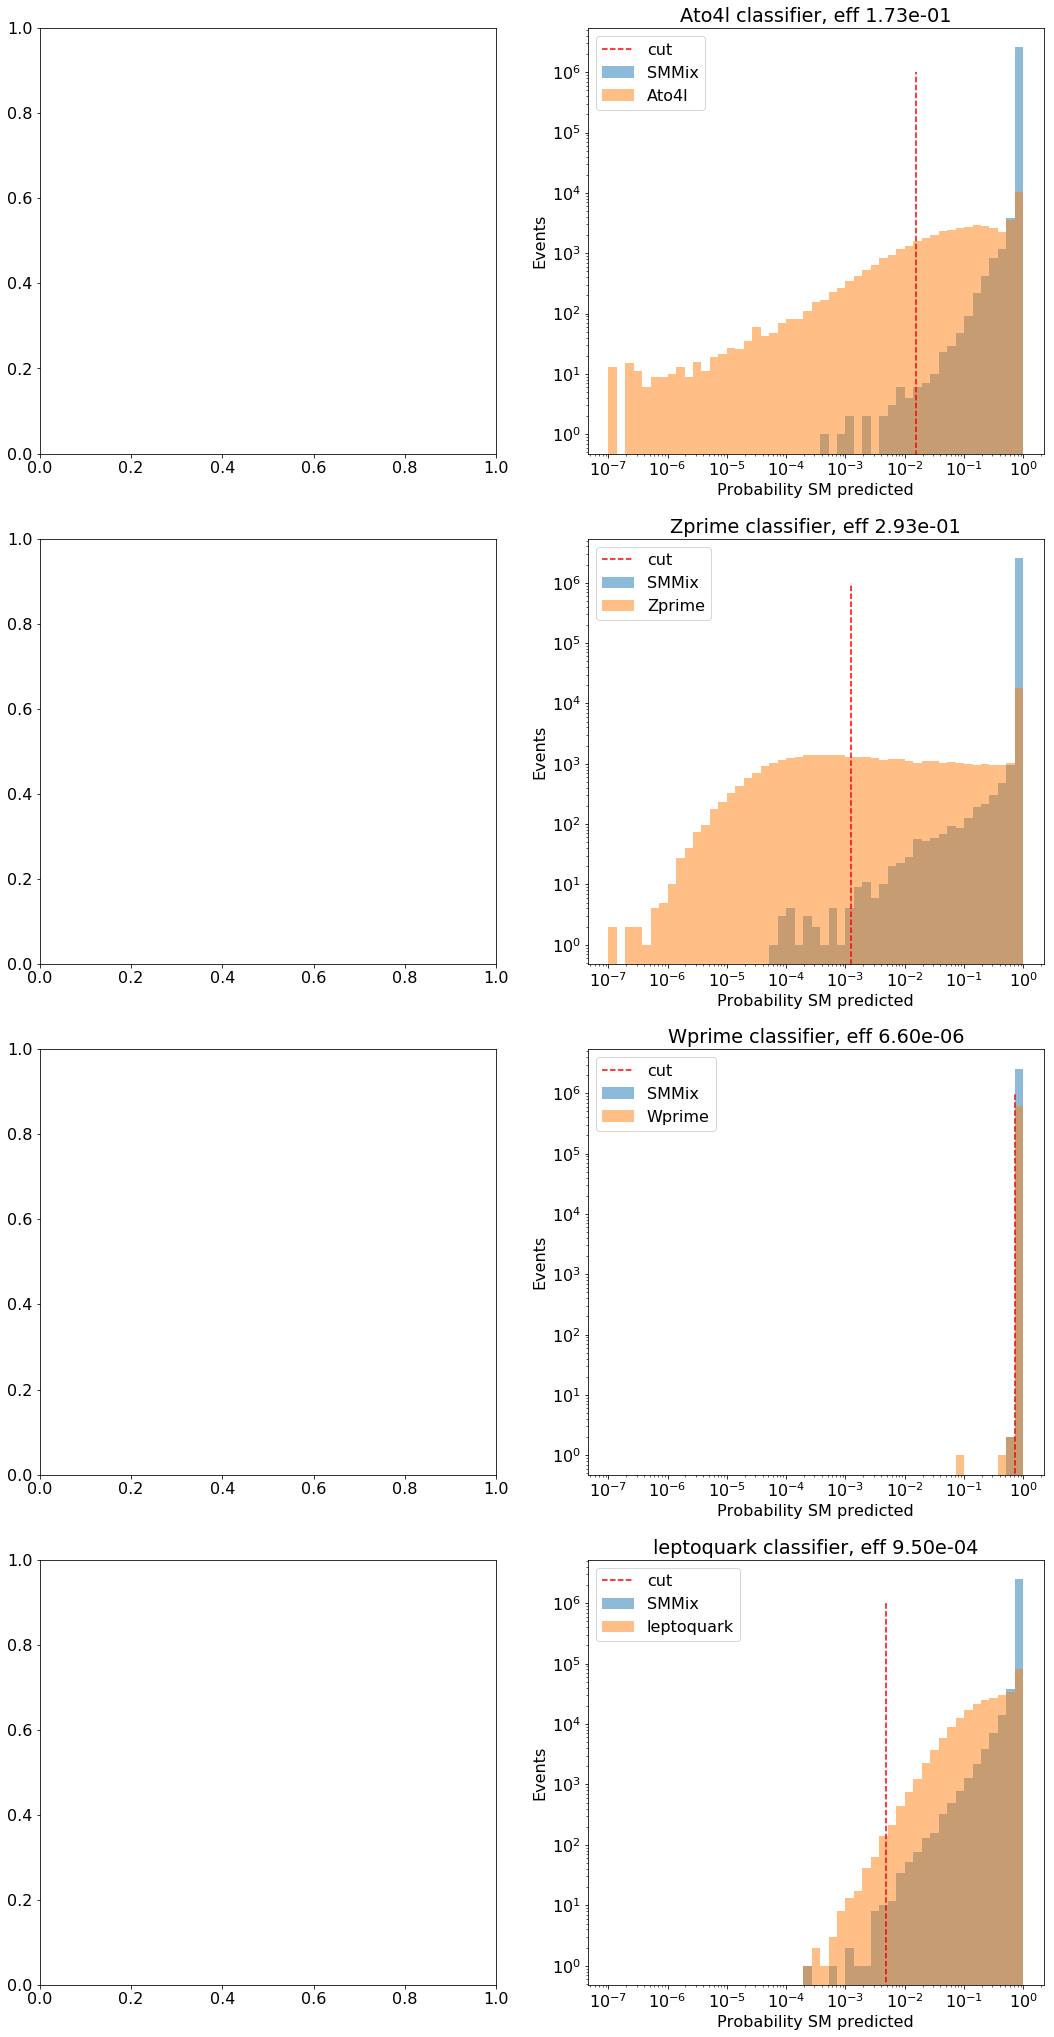

In [83]:
matplotlib.rcParams.update({'font.size': 16})

# f = plt.figure(figsize=(16,8))
# plt.plot(clf[n].training_history['loss'][1:], 'r--', label='loss')
# plt.plot(clf[n].training_history['val_loss'][1:], 'c.', label='val_loss')

# plt.xlabel('Epoch')
# plt.grid()
# plt.legend(loc='best')
# plt.yscale('log')

f, ax_arr = plt.subplots(len(BSM_samples),2 , figsize=(18,36))

for i,n in enumerate(BSM_samples):
    p_SM = clf[n].predict(x_train, batch_size=2000)
    p_BSM = clf[n].predict(x_sig[n], batch_size=2000)

    q = np.percentile(p_SM, 100*(1-Eff_SM))
    eff_BSM = float(np.sum(p_BSM>q))/x_sig[n].shape[0]

#     print eff_BSM

    bins = np.logspace(base=10, start=-7, stop=0, num=50)
    ax_arr[i,1].hist(1-p_SM, bins=bins, alpha = 0.5, label='SMMix')
    ax_arr[i,1].hist(1-p_BSM, bins=bins, alpha=0.5, label=n)
    ax_arr[i,1].plot([1-q,1-q], [0,1e6], '--r', label='cut')

    ax_arr[i,1].set_title('{} classifier, eff {:1.2e}'.format(n, eff_BSM))
    ax_arr[i,1].legend(loc='best')
    ax_arr[i,1].set_ylabel('Events')
    ax_arr[i,1].set_xlabel('Probability SM predicted')
    ax_arr[i,1].set_yscale('log')
    ax_arr[i,1].set_xscale('log')